This notebook is mostly the same as LSTM-gates-investigation.ipynb, but with longer sequences and a large number of epochs.

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mlp

mlp.style.use('classic')

%matplotlib inline

In [2]:
import numpy as np

from keras.models import Model
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping
from keras.layers import Input, LSTM, LSTMCell, Dense, SimpleRNN
from keras.utils.vis_utils import plot_model
from keras import backend as K

Using TensorFlow backend.


In [3]:
def sigmoid(a):
    return 1 / (1 + np.exp(-a))

In [4]:
seq_len = 150
N = 10000
batch_size = 100

xs = np.zeros((N, seq_len))
ys = np.zeros(N)

# construct input data
positive_indexes = np.arange(N // 2)
negative_indexes = np.arange(N // 2, N)

xs[positive_indexes, 0] = 1
ys[positive_indexes] = 1

xs[negative_indexes, 0] = -1
ys[negative_indexes] = 0

noise = np.random.normal(loc=0, scale=0.1, size=(N, seq_len))

train_xs = (xs + noise).reshape(N, seq_len, 1)
train_ys = ys

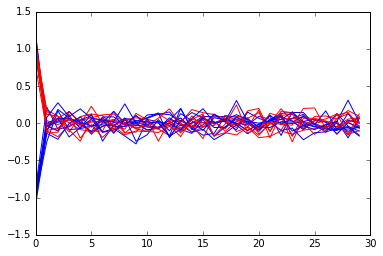

In [5]:
for i in range(10):
    plt.plot(train_xs[i], color='red')
    plt.plot(train_xs[-i], color='blue')

In [6]:
%%time
inputs = Input(shape=(None, 1), name='input')
rnn = LSTM(1, input_shape=(None, 1), name='rnn')
rnn_out = rnn(inputs)
dense = Dense(1, activation='sigmoid', name='output')
dense_out = dense(rnn_out)
model = Model(inputs, dense_out)
optm = Adam(lr=1e-3)
# optm = SGD(lr=1e-5, decay=1e-6, momentum=0.9, nesterov=True)
# model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=optm, loss='mse')

hist = model.fit(train_xs, train_ys,
                 batch_size=batch_size,
                 epochs=1000,
                 validation_split=0.2, 
                 verbose=1,
                 callbacks = [EarlyStopping(monitor='loss', min_delta=1e-5)]
                )

Train on 8000 samples, validate on 2000 samples
Epoch 1/1000
8000/8000 [==============================] - 2s 287us/step - loss: 0.2462 - val_loss: 0.2877
Epoch 2/1000
8000/8000 [==============================] - 2s 218us/step - loss: 0.2388 - val_loss: 0.3537
Epoch 3/1000
8000/8000 [==============================] - 2s 232us/step - loss: 0.2358 - val_loss: 0.3787
Epoch 4/1000
8000/8000 [==============================] - 2s 222us/step - loss: 0.2350 - val_loss: 0.3873
Epoch 5/1000
8000/8000 [==============================] - 2s 222us/step - loss: 0.2348 - val_loss: 0.3908
Epoch 6/1000
8000/8000 [==============================] - 2s 220us/step - loss: 0.2346 - val_loss: 0.3902
Epoch 7/1000
8000/8000 [==============================] - 2s 220us/step - loss: 0.2346 - val_loss: 0.3915
Epoch 8/1000
8000/8000 [==============================] - 2s 232us/step - loss: 0.2345 - val_loss: 0.3907
Epoch 9/1000
8000/8000 [==============================] - 2s 229us/step - loss: 0.2344 - val_loss: 0.392

8000/8000 [==============================] - 2s 218us/step - loss: 9.4630e-04 - val_loss: 8.9700e-04
Epoch 78/1000
8000/8000 [==============================] - 2s 211us/step - loss: 9.1731e-04 - val_loss: 8.8201e-04
Epoch 79/1000
8000/8000 [==============================] - 2s 212us/step - loss: 8.8966e-04 - val_loss: 8.6643e-04
Epoch 80/1000
8000/8000 [==============================] - 2s 219us/step - loss: 8.6317e-04 - val_loss: 8.5006e-04
Epoch 81/1000
8000/8000 [==============================] - 2s 222us/step - loss: 8.3775e-04 - val_loss: 8.3300e-04
Epoch 82/1000
8000/8000 [==============================] - 2s 214us/step - loss: 8.1332e-04 - val_loss: 8.1486e-04
Epoch 83/1000
8000/8000 [==============================] - 2s 211us/step - loss: 7.8978e-04 - val_loss: 7.9645e-04
Epoch 84/1000
8000/8000 [==============================] - 2s 214us/step - loss: 7.6709e-04 - val_loss: 7.7763e-04
Epoch 85/1000
8000/8000 [==============================] - 2s 212us/step - loss: 7.4519e-04 - 

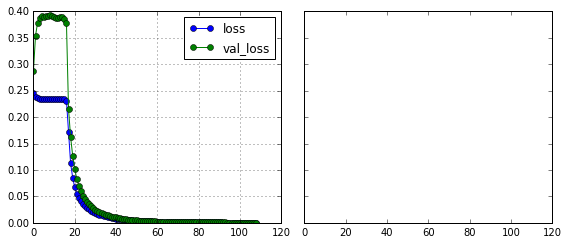

In [7]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8, 3.5))
axes = axes.ravel()

for k, keys in enumerate([['loss', 'val_loss'],
#                           ['acc', 'val_acc']
                         ]):
    ax = axes[k]
    
    for key in keys:
        ax.plot(hist.history[key], 'o-', label=key)
    ax.grid()
    ax.legend(loc='best')
plt.tight_layout()

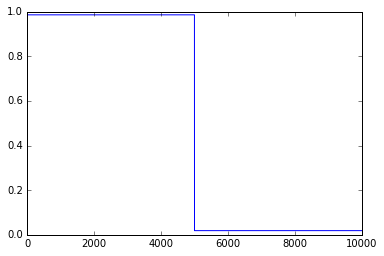

In [8]:
# the positive and negative only vary by a small difference considering output from sigmoid
plt.plot(model.predict(train_xs))

ref: http://colah.github.io/posts/2015-08-Understanding-LSTMs/

Since the input at each time step is only 1 dimension, so I used $w$ (scalar) instead of $W$ (matrix).

<img src="./lstm.png" width=600/>

Calculate gates:

\begin{align*}
f_t &= \sigma(w_f[h_{t-1}, x_t] + b_f) \\
i_t &= \sigma(w_i[h_{t-1}, x_t] + b_i) \\
\tilde{C}_t &= \tanh(w_C[h_{t-1}, x_t] + b_C) \\
o_t &= \sigma(w_o[h_{t-1}, x_t] + b_o)
\end{align*}

Update $C_t$ and $h_t$,
\begin{align*}
C_t &= f_t * C_{t-1} + i_t * \tilde{C}_t \\
h_t &= o_t * \tanh(C_t)
\end{align*}

In [9]:
rnn.get_weights()

[array([[ 7.4881846e-01, -3.9799666e-01, -9.0379053e-01, -3.7696099e-04]],
       dtype=float32),
 array([[ 0.18907575, -0.2666904 ,  1.048734  ,  0.00183203]],
       dtype=float32),
 array([0.969188  , 2.068001  , 0.18305524, 2.5023916 ], dtype=float32)]

In [10]:
# ref: https://github.com/keras-team/keras/blob/d035967a5d2795734c89a0a3c002f7eb5c34eff1/keras/layers/recurrent.py#L1865
kernel = np.array(rnn.get_weights()[:2])[:,0,:]
kernel

array([[ 7.4881846e-01, -3.9799666e-01, -9.0379053e-01, -3.7696099e-04],
       [ 1.8907575e-01, -2.6669040e-01,  1.0487339e+00,  1.8320297e-03]],
      dtype=float32)

In [11]:
w_i, w_f, w_c, w_o = kernel.T
b_i, b_f, b_c, b_o = rnn.get_weights()[-1]

In [12]:
print(w_i, b_i)
print(w_f, b_f)
print(w_c, b_c)
print(w_o, b_o)

[0.74881846 0.18907575] 0.969188
[-0.39799666 -0.2666904 ] 2.068001
[-0.90379053  1.048734  ] 0.18305524
[-0.00037696  0.00183203] 2.5023916


In [13]:
d_w0 = dense.get_weights()[0][0]
d_b0 = dense.get_weights()[1]
print(d_w0, d_b0)

[-4.0906587] [0.1274348]


In [14]:
for k, single_x in enumerate([train_xs[0], train_xs[1], train_xs[-2], train_xs[-1]]):
    h_prev = 0
    C_prev = 0

    hist = []
    for t in range(single_x.shape[0]):
    #     cat_x = [h_prev, single_x[t][0]]
        cat_x = [single_x[t][0], h_prev]
        f_t = sigmoid(np.dot(w_f, cat_x) + b_f)
        i_t = sigmoid(np.dot(w_i, cat_x) + b_i)
        B_t = np.tanh(np.dot(w_c, cat_x) + b_c) # use B to mean \tilde{C}
        o_t = sigmoid(np.dot(w_o, cat_x) + b_o)

        C_t = f_t * C_prev + i_t * B_t
        h_t = o_t * np.tanh(C_t)

        hist.append([f_t, i_t, B_t, o_t, C_t, h_t])

        h_prev = h_t
        C_prev = C_t
    den_in = hist[-1][-1]
    out = sigmoid(den_in * d_w0 + d_b0)
    print(out, model.predict(np.array([single_x])))

[0.9803003] [[0.985487]]
[0.98029995] [[0.9854871]]
[0.02526205] [[0.01867367]]
[0.025259] [[0.01867065]]


The mannual process and model prediction are highly correlated, but still not the same...., in constrast to simpler SimpleRNN process in another notebook.

# Single x debugging and time step visualization

In [24]:
single_x = train_xs[5]
# single_x

In [16]:
h_prev = 0
C_prev = 0

hist = []
for t in range(single_x.shape[0]):
#     cat_x = [h_prev, single_x[t][0]]
    cat_x = [single_x[t][0], h_prev]
    f_t = sigmoid(np.dot(w_f, cat_x) + b_f)
    i_t = sigmoid(np.dot(w_i, cat_x) + b_i)
    B_t = np.tanh(np.dot(w_c, cat_x) + b_c) # use B to mean \tilde{C}
    o_t = sigmoid(np.dot(w_o, cat_x) + b_o)

    C_t = f_t * C_prev + i_t * B_t
    h_t = o_t * np.tanh(C_t)

    hist.append([f_t, i_t, B_t, o_t, C_t, h_t])

    h_prev = h_t
    C_prev = C_t

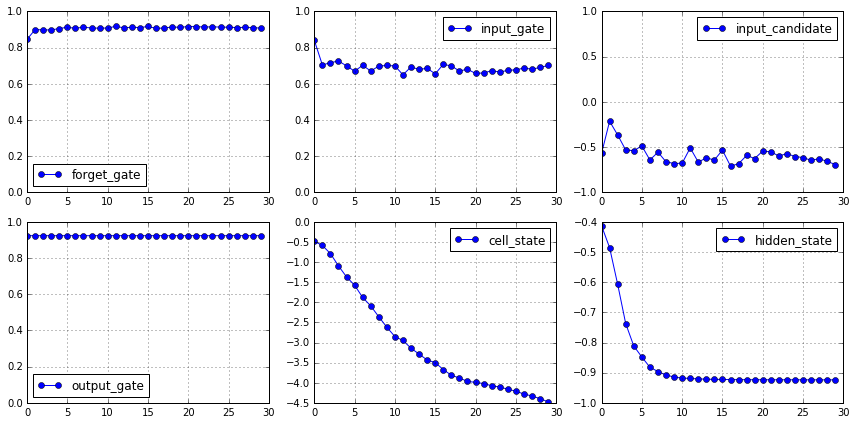

In [17]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6), 
#                          sharex=True, sharey=True
                        )
axes = axes.ravel()

for k, i in enumerate([
    'forget_gate', 'input_gate', 'input_candidate', 'output_gate', 
    'cell_state', 'hidden_state'
]):
    ax = axes[k]
    ax.plot(np.array(hist)[:,k], 'o-', label=i)
    ax.legend(loc='best')
    ax.grid()
    
    if k in [0, 1, 3]:
        ax.set_ylim(0, 1)
    if k == 2:
        ax.set_ylim(-1, 1)

plt.tight_layout()

So seems that `input_candidate` are completely ignored

In [18]:
dense.get_weights()

[array([[-4.0906587]], dtype=float32), array([0.1274348], dtype=float32)]

In [19]:
# den_in = hist[-1][-1] # dense input
den_in = hist[-1][-1]

In [20]:
den_in

-0.923949012815889

In [21]:
d_w0 = dense.get_weights()[0][0]
d_b0 = dense.get_weights()[1]
print(d_w0, d_b0)

[-4.0906587] [0.1274348]


In [22]:
sigmoid(den_in * d_w0 + d_b0)

array([0.98029524], dtype=float32)

In [23]:
model.predict(np.array([single_x]))

array([[0.985487]], dtype=float32)

Followed equations from [colah's blog](http://colah.github.io/posts/2015-08-Understanding-LSTMs/), but there is always inconsistency.... 